## Importing Libraries


---



In [13]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from keras.layers import Input, Dense
from keras.models import Model

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

## Load Data

---



In [2]:
transform = transforms.ToTensor() # Automatically convert into [0,1] pixel values

train_data = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform = transform
)

test_data = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform = transform
)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.10MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.29MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.15MB/s]


## Normalize Data

---



In [3]:
X_train = train_data.data.unsqueeze(1).float() / 255 # Unsqueeze to add a channel - here 1 in this case grayscale
X_test = test_data.data.unsqueeze(1).float() / 255

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

X_train shape: torch.Size([60000, 1, 28, 28])
X_test shape: torch.Size([10000, 1, 28, 28])
60000 train samples
10000 test samples


## Flatten for fully-connected networks

---

This is done to convert 2D-images into 1D-image as Dense layers don't understand them.





In [4]:
X_train_flat = X_train.reshape(60000, 28*28)
X_test_flat = X_test.reshape(10000, 28*28)

print(X_train_flat.shape)
print(X_test_flat.shape)

torch.Size([60000, 784])
torch.Size([10000, 784])


# Vanilla Autoencoder

---

Creating network



In [5]:
input_size = 784 # (28*28) flattened pixels
hidden_size = 64 # Compression (latent space)
output_size = 784 # Reconstruction of image

In [6]:
x = Input(shape=(input_size,))
h = Dense(hidden_size, activation='relu')(x)
r = Dense(output_size, activation='sigmoid')(h)

In [7]:
class Autoencoder(nn.Module):
  def __init__(self,input_size, hidden_size, output_size):
    super(Autoencoder, self).__init__()

    self.encoder = nn.Linear(input_size, hidden_size)
    self.decoder = nn.Linear(hidden_size, output_size)

  def forward(self,x):
    h = F.relu(self.encoder(x))
    r = torch.sigmoid(self.decoder(h))
    return r

model = Autoencoder(input_size = input_size, hidden_size = hidden_size, output_size = output_size)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.MSELoss()

In [8]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 128
epochs = 5

train_loader = DataLoader(
    TensorDataset(X_train_flat, X_train_flat),
    batch_size = batch_size,
    shuffle = True
)

val_loader = DataLoader(
    TensorDataset(X_test_flat, X_test_flat),
    batch_size = batch_size,
    shuffle = False
)

In [9]:
train_losses = []
val_losses = []

for epoch in range(epochs):
  model.train()
  running_loss = 0

  for x, _ in train_loader:
    output = model(x)
    loss = criterion(output, x)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  train_loss = running_loss / len(train_loader)
  train_losses.append(train_loss)

  model.eval()
  val_loss = 0
  with torch.no_grad():
    for x, _ in val_loader:
      output = model(x)
      val_loss += criterion(output, x).item()

  val_loss /= len(val_loader)
  val_losses.append(val_loss)

  print(f"Epoch {epoch+1}/{epochs} | loss: {train_loss:.4f} | val_loss: {val_loss:.4f}")

Epoch 1/5 | loss: 0.0481 | val_loss: 0.0250
Epoch 2/5 | loss: 0.0198 | val_loss: 0.0150
Epoch 3/5 | loss: 0.0129 | val_loss: 0.0105
Epoch 4/5 | loss: 0.0095 | val_loss: 0.0081
Epoch 5/5 | loss: 0.0077 | val_loss: 0.0069


In [11]:
with torch.no_grad():
    encoded_imgs = F.relu(model.encoder(X_test_flat))

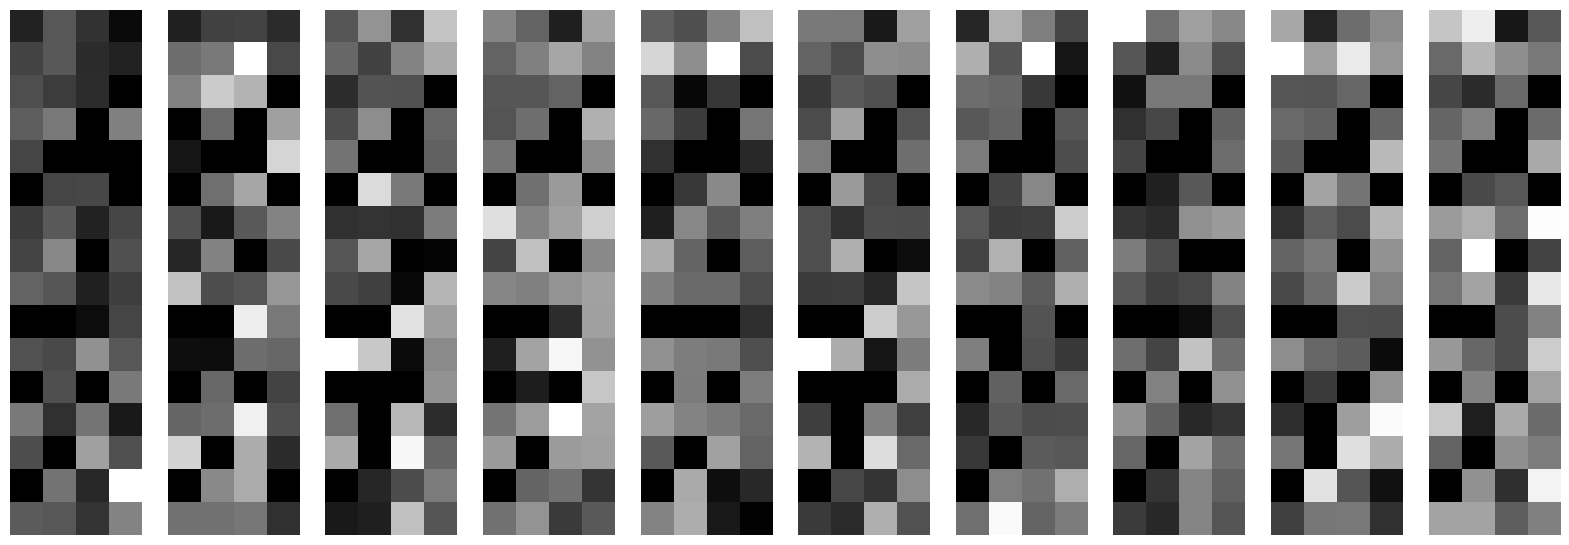

In [14]:
encoded_imgs_np = encoded_imgs.cpu().numpy()

n = 10
plt.figure(figsize=(20,8))
for i in range(n):
  ax = plt.subplot(1,n,i+1)
  plt.imshow(encoded_imgs_np[i].reshape(4,16).T)
  plt.gray()
  ax.axis('off')
plt.show()

In [15]:
model.eval()
with torch.no_grad():
  decoded_imgs = model(X_test_flat)

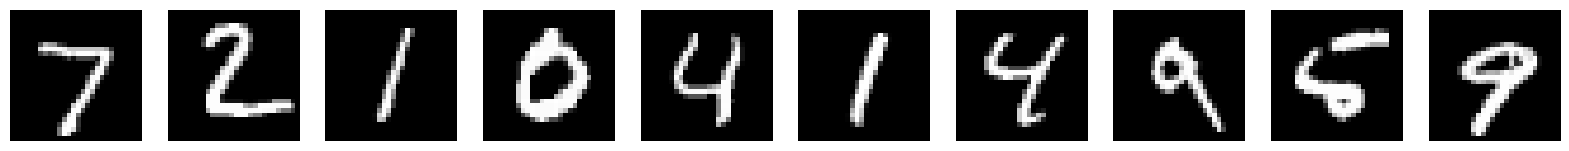

In [18]:
n = 10
plt.figure(figsize=(20,6))
for i in range(n):
  ax = plt.subplot(3, n, i+1)
  plt.imshow(X_test[i].reshape(28,28))
  plt.gray()
  ax.axis("off")
plt.show()

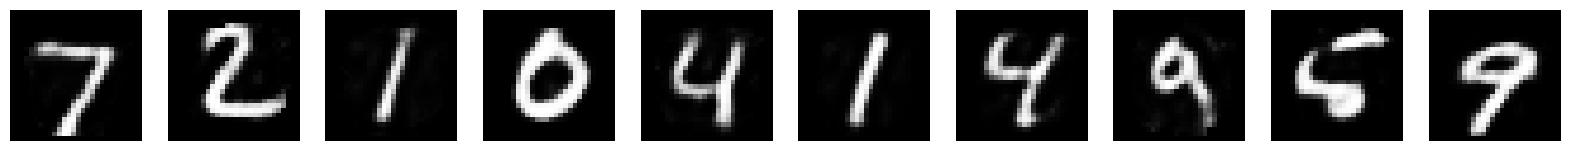

In [19]:
n = 10
plt.figure(figsize=(20,6))
for i in range(n):
  ax = plt.subplot(3, n, i+1)
  plt.imshow(decoded_imgs[i].reshape(28,28))
  plt.gray()
  ax.axis("off")
plt.show()

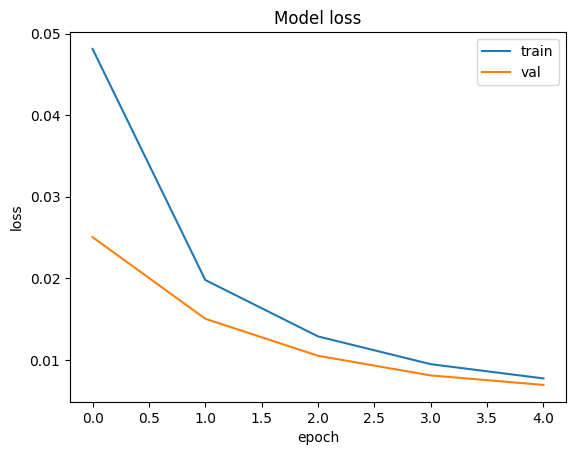

In [20]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train","val"], loc="upper right")
plt.show()

# Multilayer Autoencoder

In [21]:
input_size = 784
hidden_size = 128
code_size = 64
output_size = 784

In [22]:
x = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(x)
h = Dense(code_size, activation = 'relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(h)
r = Dense(output_size, activation='sigmoid')(hidden_2)

In [24]:
class MultilayerAutoencoder(nn.Module):
  def __init__(self, input_size, hidden_size, code_size, output_size):
    super(MultilayerAutoencoder, self).__init__()

    self.enc1 = nn.Linear(input_size, hidden_size)
    self.enc2 = nn.Linear(hidden_size, code_size)

    self.dec1 = nn.Linear(code_size, hidden_size)
    self.dec2 = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    x = F.relu(self.enc1(x))
    code = F.relu(self.enc2(x))
    x = F.relu(self.dec1(code))
    x = torch.sigmoid(self.dec2(x))
    return x

model = MultilayerAutoencoder(input_size = input_size, hidden_size = hidden_size, code_size = code_size, output_size = output_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss

In [25]:
batch_size = 128
epochs = 5

train_loader = DataLoader(
    TensorDataset(X_train_flat, X_train_flat),
    batch_size = batch_size,
    shuffle=True
)

test_loader = DataLoader(
    TensorDataset(X_test_flat, X_test_flat),
    batch_size = batch_size,
    shuffle = False
)